In [58]:
import sys
from dataclasses import dataclass
import numpy as np
import pandas as pd
from scipy import stats
from math import sqrt
from collections import defaultdict, Counter
from pathlib import Path
from itertools import product
from enum import Enum
import matplotlib as mpl
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import seaborn as sns

In [59]:
plt.style.use("ggplot")

In [60]:
@dataclass
class ConfusionMatrix:
    tp: int = 0
    tn: int = 0
    fp: int = 0
    fn: int = 0

    def ravel(self) -> tuple[int, int, int, int]:
        """Return the matrix as a flattened tuple.
        The order of return is TN, FP, FN, TP
        """
        return self.tn, self.fp, self.fn, self.tp

    def as_matrix(self) -> np.ndarray:
        """Returns a 2x2 matrix [[TN, FP], [FN, TP]]"""
        return np.array([[self.tn, self.fp], [self.fn, self.tp]])

    def num_positive(self) -> int:
        """Number of TPs and FNs - i.e. actual condition positive"""
        return self.tp + self.fn

    def num_negative(self) -> int:
        """Number of TNs and FPs - i.e. actual condition negative"""
        return self.tn + self.fp

    def sensitivity(self) -> tuple[float, float, float]:
        """Also known as recall and true positive rate (TPR)"""
        try:
            sn = self.tp / (self.tp + self.fn)
            lwr_bound, upr_bound = confidence_interval(n_s=self.tp, n_f=self.fn)
            return sn, lwr_bound, upr_bound
        except ZeroDivisionError:
            return None, None, None

    def specificity(self) -> tuple[float, float, float]:
        """Also known as selectivity and true negative rate (TNR)"""
        try:
            sp = self.tn / (self.tn + self.fp)
            lwr_bound, upr_bound = confidence_interval(n_s=self.tn, n_f=self.fp)
            return sp, lwr_bound, upr_bound
        except ZeroDivisionError:
            return None, None, None

    def mcc(self) -> float | None:
        """Matthews correlation coefficient"""
        numerator = (self.tp * self.tn) - (self.fp * self.fn)
        denominator = (
            (self.tp + self.fp)
            * (self.tp + self.fn)
            * (self.tn + self.fp)
            * (self.tn + self.fn)
        )
        try:
            return numerator / sqrt(denominator)
        except ZeroDivisionError:
            return None

    @staticmethod
    def from_series(s: pd.Series) -> "ConfusionMatrix":
        tp = s.get("TP", 0)
        fp = s.get("FP", 0)
        fn = s.get("FN", 0)
        tn = s.get("TN", 0)
        return ConfusionMatrix(tp=tp, fn=fn, fp=fp, tn=tn)


def confidence_interval(n_s: int, n_f: int, conf: float = 0.95) -> tuple[float, float]:
    """Calculate the Wilson score interval.
    Equation take from https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Wilson_score_interval
    n_s: Number of successes or, in the case of confusion matrix statistics, the numerator
    n_f: Number of failures or, in the case of confusion matrix statistics, the denominator minus the numerator
    conf: the confidence level. i.e. 0.95 is 95% confidence
    """
    n = n_f + n_s
    z = stats.norm.ppf(1 - (1 - conf) / 2)  # two-sided
    z2 = z**2
    nz2 = n + z2
    A = (n_s + (0.5 * z2)) / nz2
    B = z / nz2
    C = sqrt(((n_s * n_f) / n) + (z2 / 4))
    CI = B * C
    return A - CI, A + CI


def round_up_to_base(x, base=10):
    return int(x + (base - x) % base)


def round_down_to_base(x, base=10):
    return int(x - (x % base))

class Prediction(Enum):
    Resistant = "R"
    Susceptible = "S"
    MinorResistance = "r"
    Unknown = "U"
    MinorUnknown = "u"
    Failed = "F"

    def __str__(self) -> str:
        return self.value


class Classification(Enum):
    TruePositive = "TP"
    FalsePositive = "FP"
    TrueNegative = "TN"
    FalseNegative = "FN"

    def __str__(self) -> str:
        return self.value


class Classifier:
    def __init__(
        self,
        minor_is_susceptible: bool = False,
        unknown_is_resistant: bool = False,
        failed_is_resistant: bool = False,
    ):
        self.minor_is_susceptible = minor_is_susceptible
        self.unknown_is_resistant = unknown_is_resistant
        self.failed_is_resistant = failed_is_resistant
        self.susceptible = {Prediction.Susceptible}
        self.resistant = {Prediction.Resistant}
        if self.minor_is_susceptible:
            self.susceptible.add(Prediction.MinorResistance)
        else:
            self.resistant.add(Prediction.MinorResistance)

        if self.unknown_is_resistant:
            self.resistant.add(Prediction.Unknown)
            self.resistant.add(Prediction.MinorUnknown)
        else:
            self.susceptible.add(Prediction.Unknown)
            self.susceptible.add(Prediction.MinorUnknown)

        if self.failed_is_resistant:
            self.resistant.add(Prediction.Failed)
        else:
            self.susceptible.add(Prediction.Failed)

    def from_predictions(
        self, y_true: Prediction, y_pred: Prediction
    ) -> Classification:
        if y_true in self.susceptible:
            expected_susceptible = True
        elif y_true in self.resistant:
            expected_susceptible = False
        else:
            raise NotImplementedError(f"Don't know how to classify {y_true} calls yet")

        if y_pred in self.susceptible:
            called_susceptible = True
        elif y_pred in self.resistant:
            called_susceptible = False
        else:
            raise NotImplementedError(f"Don't know how to classify {y_pred} calls yet")

        if expected_susceptible and called_susceptible:
            return Classification.TrueNegative
        elif expected_susceptible and not called_susceptible:
            return Classification.FalsePositive
        elif not expected_susceptible and not called_susceptible:
            return Classification.TruePositive
        else:
            return Classification.FalseNegative


In [61]:
tech = "illumina"
ignore_drugs = ("all", "ciprofloxacin")

In [62]:
qc = pd.read_csv(f"../../results/QC/{tech}.qc.csv", index_col="run")
qc

,coverage,f_keep,f_contam,f_unmapped
run,,,,
ERR1034923,116.906700,0.993057,0.001520,0.005424
ERR1034928,100.294125,0.994730,0.001397,0.003873
ERR1034939,128.816109,0.996684,0.000915,0.002401
ERR1034972,95.890485,0.995368,0.001181,0.003451
ERR1035042,486.549780,0.995747,0.000698,0.003555
...,...,...,...,...
SRR6824622,325.424734,0.994228,0.002161,0.003611
SRR6824623,262.125039,0.992546,0.003782,0.003672
SRR6824618,292.295650,0.994373,0.001974,0.003652


In [63]:
phenotypes = pd.read_csv(f"../../config/{tech}.samplesheet.csv", index_col="run", low_memory=False)
phenotypes

,amikacin,bedaquiline,bioproject,biosample,capreomycin,ciprofloxacin,clofazimine,cycloserine,delamanid,ethambutol,...,levofloxacin,linezolid,moxifloxacin,ofloxacin,para-aminosalicylic_acid,pyrazinamide,rifabutin,rifampicin,streptomycin,thioacetazone
run,,,,,,,,,,,,,,,,,,,,,
ERR025832,NaN,NaN,PRJEB2221,SAMEA961581,NaN,NaN,NaN,NaN,NaN,S,...,NaN,NaN,NaN,NaN,NaN,S,NaN,S,NaN,NaN
ERR025833,NaN,NaN,PRJEB2221,SAMEA961610,NaN,NaN,NaN,NaN,NaN,S,...,NaN,NaN,NaN,NaN,NaN,S,NaN,S,NaN,NaN
ERR025834,NaN,NaN,PRJEB2221,SAMEA961608,NaN,NaN,NaN,NaN,NaN,S,...,NaN,NaN,NaN,NaN,NaN,S,NaN,S,NaN,NaN
ERR025835,NaN,NaN,PRJEB2221,SAMEA961609,NaN,NaN,NaN,NaN,NaN,S,...,NaN,NaN,NaN,NaN,NaN,S,NaN,S,NaN,NaN
ERR025836,NaN,NaN,PRJEB2221,SAMEA961584,NaN,NaN,NaN,NaN,NaN,S,...,NaN,NaN,NaN,NaN,NaN,S,NaN,S,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR9853303,NaN,NaN,PRJNA557083,SAMN12389199,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SRR9853304,NaN,NaN,PRJNA557083,SAMN12389192,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SRR9853305,NaN,NaN,PRJNA557083,SAMN12389193,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
max_contam = 0.05
valid_samples = qc.query("f_contam<=@max_contam").index

In [65]:
frames = []
for p in Path("../../results/depth/").rglob(f"{tech}.summary.csv"):
    tool = p.parts[-2]
    frame = pd.read_csv(p)
    frames.append(frame)

In [66]:
calls = pd.concat(frames)
calls["drug"] = calls.drug.str.lower()

In [67]:
tools = sorted(set(calls["tool"]))

In [68]:
full_depths = []
for run in calls["run"]:
    full_depths.append(qc.at[run, "coverage"])
calls["full_depth"] = full_depths

In [69]:
# remove rows where the depth being analysed is actually greater than the sample's depth
# e.g., if the sample has depth 40, we would exclude it from the 100x analysis
calls.query("depth<=full_depth and run in @valid_samples and drug not in @ignore_drugs", inplace=True)

In [70]:
for s in qc.index.difference(valid_samples):
    print(s, file=sys.stderr)

ERR2517457
ERR4872119
ERR4872193
SRR6824324
SRR6824345
SRR6824443
SRR6824501
SRR6824560
SRR6824572


In [71]:
minor_is_susceptible = False#snakemake.params.minor_is_susceptible
unknown_is_resistant = False#snakemake.params.unknown_is_resistant
failed_is_resistant = False#snakemake.params.failed_is_resistant
classifier = Classifier(
    unknown_is_resistant=unknown_is_resistant,
    minor_is_susceptible=minor_is_susceptible,
    failed_is_resistant=failed_is_resistant,
)

In [72]:
calls.set_index(
    ["run", "tool", "drug", "depth"], verify_integrity=True, inplace=True, drop=False
)

In [73]:
drugs = set()
pheno_clf = []
depths = set(calls["depth"])
for drug, tool, run, depth in product(set(calls["drug"]), tools, set(calls["run"]), depths):
    full_depth = qc.at[run, "coverage"]
    if depth > full_depth:
        continue
        
    try:
        ph = phenotypes.at[run, drug]
        if pd.isna(ph):
            continue
        else:
            truth = Prediction(ph)
    except KeyError:
        print(f"[WARN]: {run} has no phenotype column for {drug}")
        continue

    ix = (run, tool, drug, depth)
    drugs.add(drug)
    try:
        pred = calls.at[ix, "prediction"]
    except KeyError:
        
        # tbprofiler doesnt explicitly report S
        assert tool == "tbprofiler", ix
        pred = "S"
    clf = classifier.from_predictions(truth, Prediction(pred))

    pheno_clf.append((run, drug, str(clf), tool, depth))
    cols = ["run", "drug", "classification", "tool", "depth"]
df = pd.DataFrame(pheno_clf, columns=cols)

In [74]:
cms = defaultdict()

low_pheno_drugs = set()

for drug, tool, depth in product(drugs, tools, depths):
    s = df.query("drug == @drug and tool == @tool and depth == @depth").value_counts(
        subset=["classification"]
    )
    cm = ConfusionMatrix.from_series(s)
    cms[(drug, tool, depth)] = cm
    n = sum(cm.ravel())
    if n < 10:#todo snakemake.params.min_num_phenotypes:
        low_pheno_drugs.add(drug)

drugs = {d for d in drugs if d not in low_pheno_drugs}

metrics = []
for (drug, tool, depth), cm in cms.items():
    sn = cm.sensitivity()[0]
    sp = cm.specificity()[0]
    metrics.append((drug, tool, depth, sn, sp))

summary_cols = [
    "drug",
    "tool",
    "depth",
    "Sensitivity",
    "Specificity",
]

summary = pd.DataFrame(
    metrics,
    columns=summary_cols,
).melt(id_vars=["drug", "tool", "depth"], var_name="metric")

table = (
    summary.set_index(["drug", "tool", "depth", "metric"])["value"].unstack().reset_index()
)

for clf in ["TP", "FP", "FN", "TN"]:
    table[clf] = 0

for i, row in table.iterrows():
    ix = (row["drug"], row["tool"], row["depth"])
    cm = cms[ix]
    table.at[i, "TP"] = cm.tp
    table.at[i, "FP"] = cm.fp
    table.at[i, "TN"] = cm.tn
    table.at[i, "FN"] = cm.fn

for k in ["drug"]:
    table[k] = table[k].str.capitalize()

table.fillna("-", inplace=True)
summary_cols = [
    "drug",
    "tool",
    "depth",
    "Sensitivity",
    "Specificity",
    "TP",
    "TN",
    "FN",
    "FP",
]
table = table[summary_cols]

rows = []
ci_str = (
    lambda tup: f"{tup[0]:.1%} ({tup[1] * 100:.1f}-{tup[2]:.1%})"
    if tup[0] is not None
    else "-"
)
for i, row in table.iterrows():
    cm = ConfusionMatrix(tp=row["TP"], fp=row["FP"], tn=row["TN"], fn=row["FN"])
    sn = cm.sensitivity()
    sp = cm.specificity()
    mcc = cm.mcc()
    if mcc is not None:
        mcc = round(mcc, 3)
    else:
        mcc = "-"
    fn_str = f"{cm.fn}({cm.num_positive()})"
    fp_str = f"{cm.fp}({cm.num_negative()})"
    rows.append(
        (
            row["drug"].capitalize(),
            row["tool"],
            row["depth"],
            fn_str,
            fp_str,
            ci_str(sn),
            ci_str(sp),
            mcc,
        )
    )
pretty_cols = [
    "Drug",
    "Tool",
    "Depth",
    "FN(R)",
    "FP(S)",
    "Sensitivity (95% CI)",
    "Specificity (95% CI)",
    "MCC",
]
table = pd.DataFrame(rows, columns=pretty_cols)

# todo table.to_csv(snakemake.output.table, index=False)

sn_data = []
sp_data = []
df.query("drug not in @low_pheno_drugs", inplace=True)
for tool, depth, drug in product(tools, depths, drugs):
    if drug in low_pheno_drugs:
        continue

    s = df.query("tool == @tool and depth == @depth and drug == @drug").value_counts(
        subset=["classification"]
    )
    cm = ConfusionMatrix.from_series(s)
    sn = cm.sensitivity()
    sp = cm.specificity()
    sn_data.append((tool, drug, depth, *sn))
    sp_data.append((tool, drug, depth, *sp))

sn_df = pd.DataFrame(sn_data, columns=["tool", "drug", "depth", "value", "lower", "upper"])
sp_df = pd.DataFrame(sp_data, columns=["tool", "drug", "depth", "value", "lower", "upper"])

s = """AMK amikacin
CAP capreomycin
CFX ciprofloxacin
DLM delamanid
EMB ethambutol
ETO ethionamide
INH isoniazid
KAN kanamycin
LFX levofloxacin
LZD linezolid
MFX moxifloxacin
OFX ofloxacin
PZA pyrazinamide
RIF rifampicin
STM streptomycin"""
long2short = dict()
for line in s.splitlines():
    ab, d = line.split()
    long2short[d] = ab

short2long = dict()
for line in s.splitlines():
    ab, d = line.split()
    short2long[ab] = d

first_line = [short2long[d] for d in ["INH", "RIF", "EMB", "PZA"]]
fluoroquinolones = [short2long[d] for d in ["LFX", "MFX", "OFX", "CFX"]]  # group A
macrolides = [
    short2long[d] for d in ["AMK", "CAP", "KAN", "STM"]
]  # group B - second-line injectables
other = [short2long[d] for d in ["ETO", "LZD", "DLM"]]  # group C and D
drug_order = [
    d for d in [*first_line, *fluoroquinolones, *macrolides, *other] if d in drugs
]

def sort_drugs(a):
    xs = drug_order
    out = []
    c = Counter()
    for x in a:
        i = xs.index(x)
        d = xs[i]
        c[d] += 1
        out.append((i, c[d]))
    return out

sn_df = sn_df.sort_values(by="depth").reset_index(drop=True)
sp_df = sp_df.sort_values(by="depth").reset_index(drop=True)

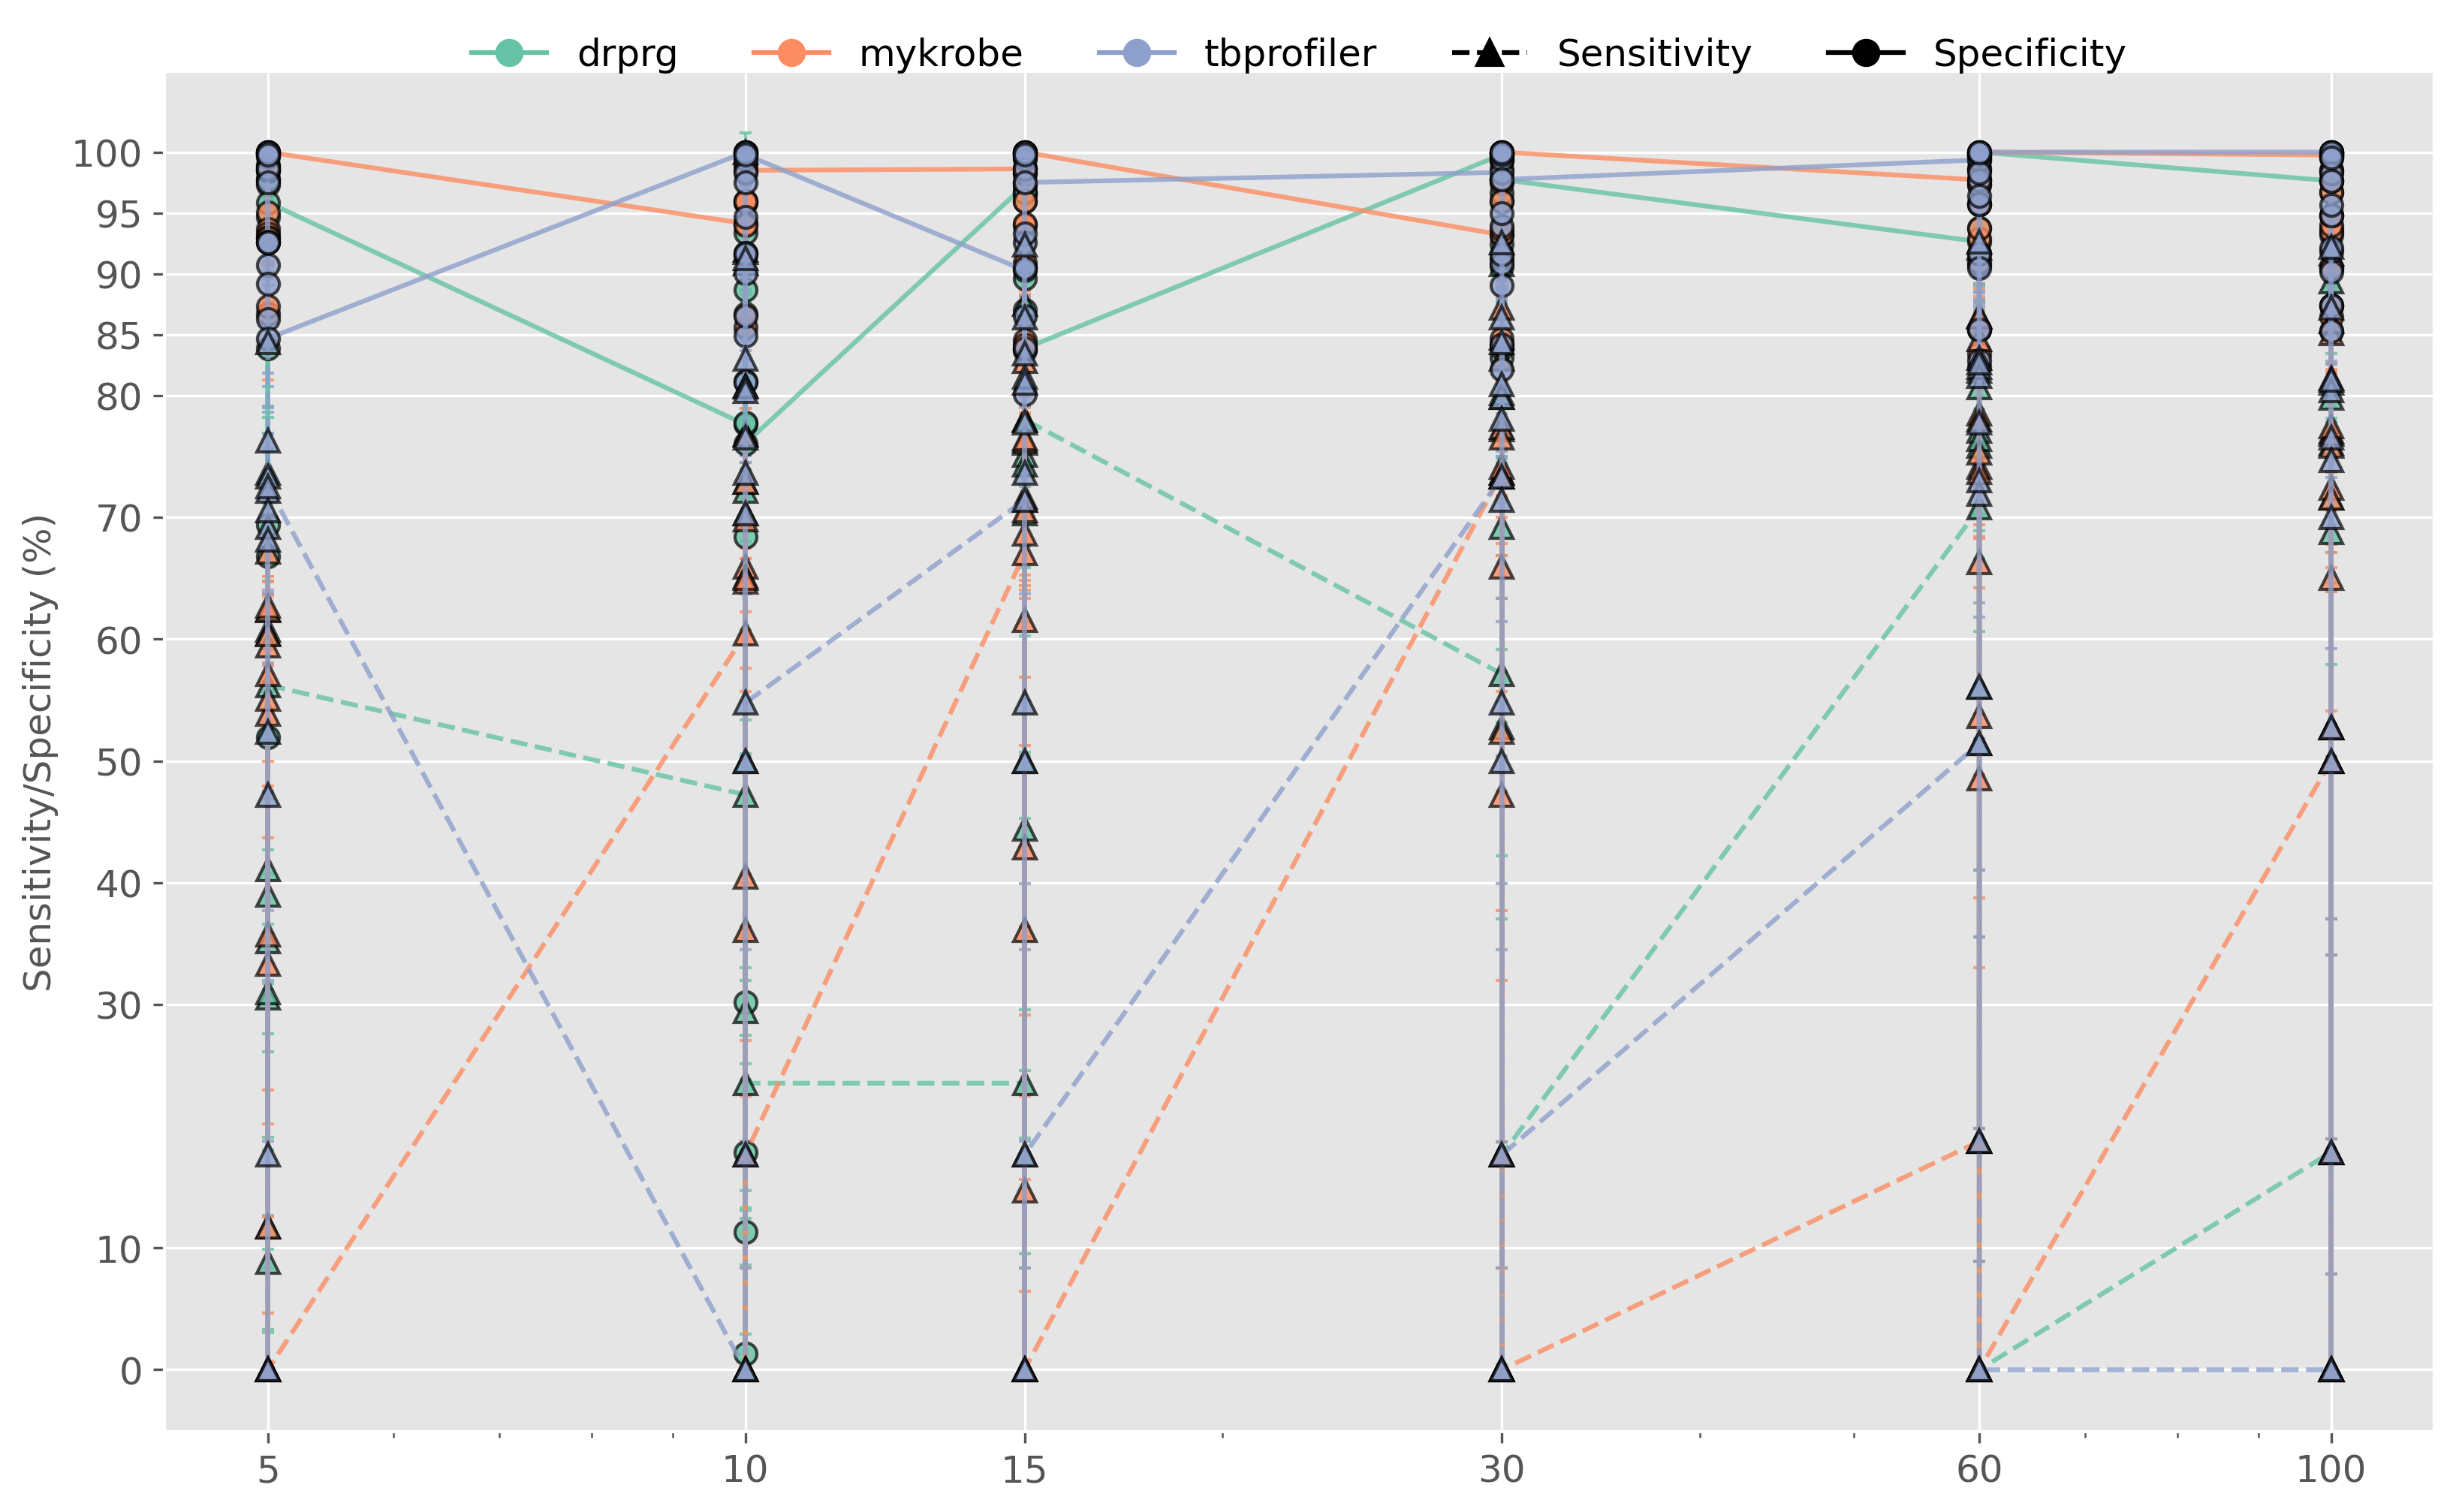

In [75]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)

x = "depth"
y = "value"
elw = 1
marker_size = 7
capsize = 2
cmap = plt.get_cmap("Set2").colors
edge_alpha = 0.7
fs = 12
edgecol = mpl.colors.to_rgba("black", alpha=edge_alpha)
leg_marker_size = 8

sn_marker = "^"
sn_line = "--"
sp_marker = "o"
sp_line = "-"

i = -1

leghandles = []

for tool in tools:
    i += 1
    tool_sn_df = sn_df.query("tool==@tool")
    tool_sp_df = sp_df.query("tool==@tool")

    colour = mpl.colors.to_rgba(cmap[i], alpha=0.8)
    label = tool


    sp_ys = tool_sp_df["value"] * 100
    sp_lb = sp_ys - tool_sp_df["lower"] * 100
    sp_ub = tool_sp_df["upper"] * 100 - sp_ys
    sp_ub = [min(100, x) for x in sp_ub]

    
    plotprops = dict(
        label=label, 
        color=colour, 
        capsize=capsize, 
        elinewidth=elw,
        mec=edgecol,
        markersize=marker_size,
    )
    
    sp_bar = ax.errorbar(
        x=tool_sp_df[x], 
        y=sp_ys,
        yerr=[sp_lb, sp_ub],
        fmt=f"{sp_marker}{sp_line}",
        **plotprops
    )
    
    sn_ys = tool_sn_df["value"] * 100
    sn_lb = sn_ys - tool_sn_df["lower"] * 100
    sn_ub = tool_sn_df["upper"] * 100 - sn_ys
    sn_ub = [min(100, x) for x in sp_ub]


    
    sn_bar = ax.errorbar(
        x=tool_sn_df[x], 
        y=sn_ys,
        yerr=[sn_lb, sn_ub],
        fmt=f"{sn_marker}{sn_line}",
        **plotprops
    )
    
    h = mlines.Line2D([], [], color=cmap[i], marker=sp_marker,
                      markersize=leg_marker_size, label=label)
    leghandles.append(h)
    
# labels = [long2short[d] for d in drug_order]
# label_pos = [np.mean(ps) for ps in zip(*all_positions)]
# plt.xticks(label_pos, labels, rotation=rotate, fontsize=fs)
ax.set_ylabel("Sensitivity/Specificity (%)")
yticks = [0, 10, 30, 40, 50, 60, 70, 80, 85, 90, 95, 100]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)


# ax.set_xticks(label_pos)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=rotate, fontsize=fs)
ax.tick_params("both", labelsize=fs)

ax.set_xscale("log")
xticks = sorted(set(sn_df["depth"]))
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)

leghandles.append(mlines.Line2D([], [], color="black", marker=sn_marker, linestyle=sn_line,
                          markersize=leg_marker_size, label="Sensitivity"))
leghandles.append(mlines.Line2D([], [], color="black", marker=sp_marker, linestyle=sp_line,
                          markersize=leg_marker_size, label="Specificity"))

legend_props = dict(
    loc="upper center", 
    prop=dict(size=fs), 
    frameon=False, 
#     title_fontproperties=dict(size=fs-1, weight="bold"),
#     shadow=True,
    ncol=len(leghandles),
#     fancybox=True
)
ax.legend(handles=leghandles, bbox_to_anchor=(0.5, 1.05), **legend_props)
# axS.legend(leghandles[-2:], leglabels[-2:], title="Walker et al.", bbox_to_anchor=(1, 0.68), **legend_props)

# ax.grid(False, axis="x",)
# draw line between drug bars
# for xpos in all_positions[-1]:
#     vpos = xpos+epsilon+bar_width
#     ax.axvline(vpos, color="white", linestyle="-", alpha=1, linewidth=6)
    
# xlim = (all_positions[0][0]-(epsilon+bar_width), vpos+(epsilon))
# ax.set_xlim(xlim)
# _ = ax.set_xlabel("Drug", fontsize=fs+2)

In [76]:
import math
math.ceil(len(drugs) / 4)

4

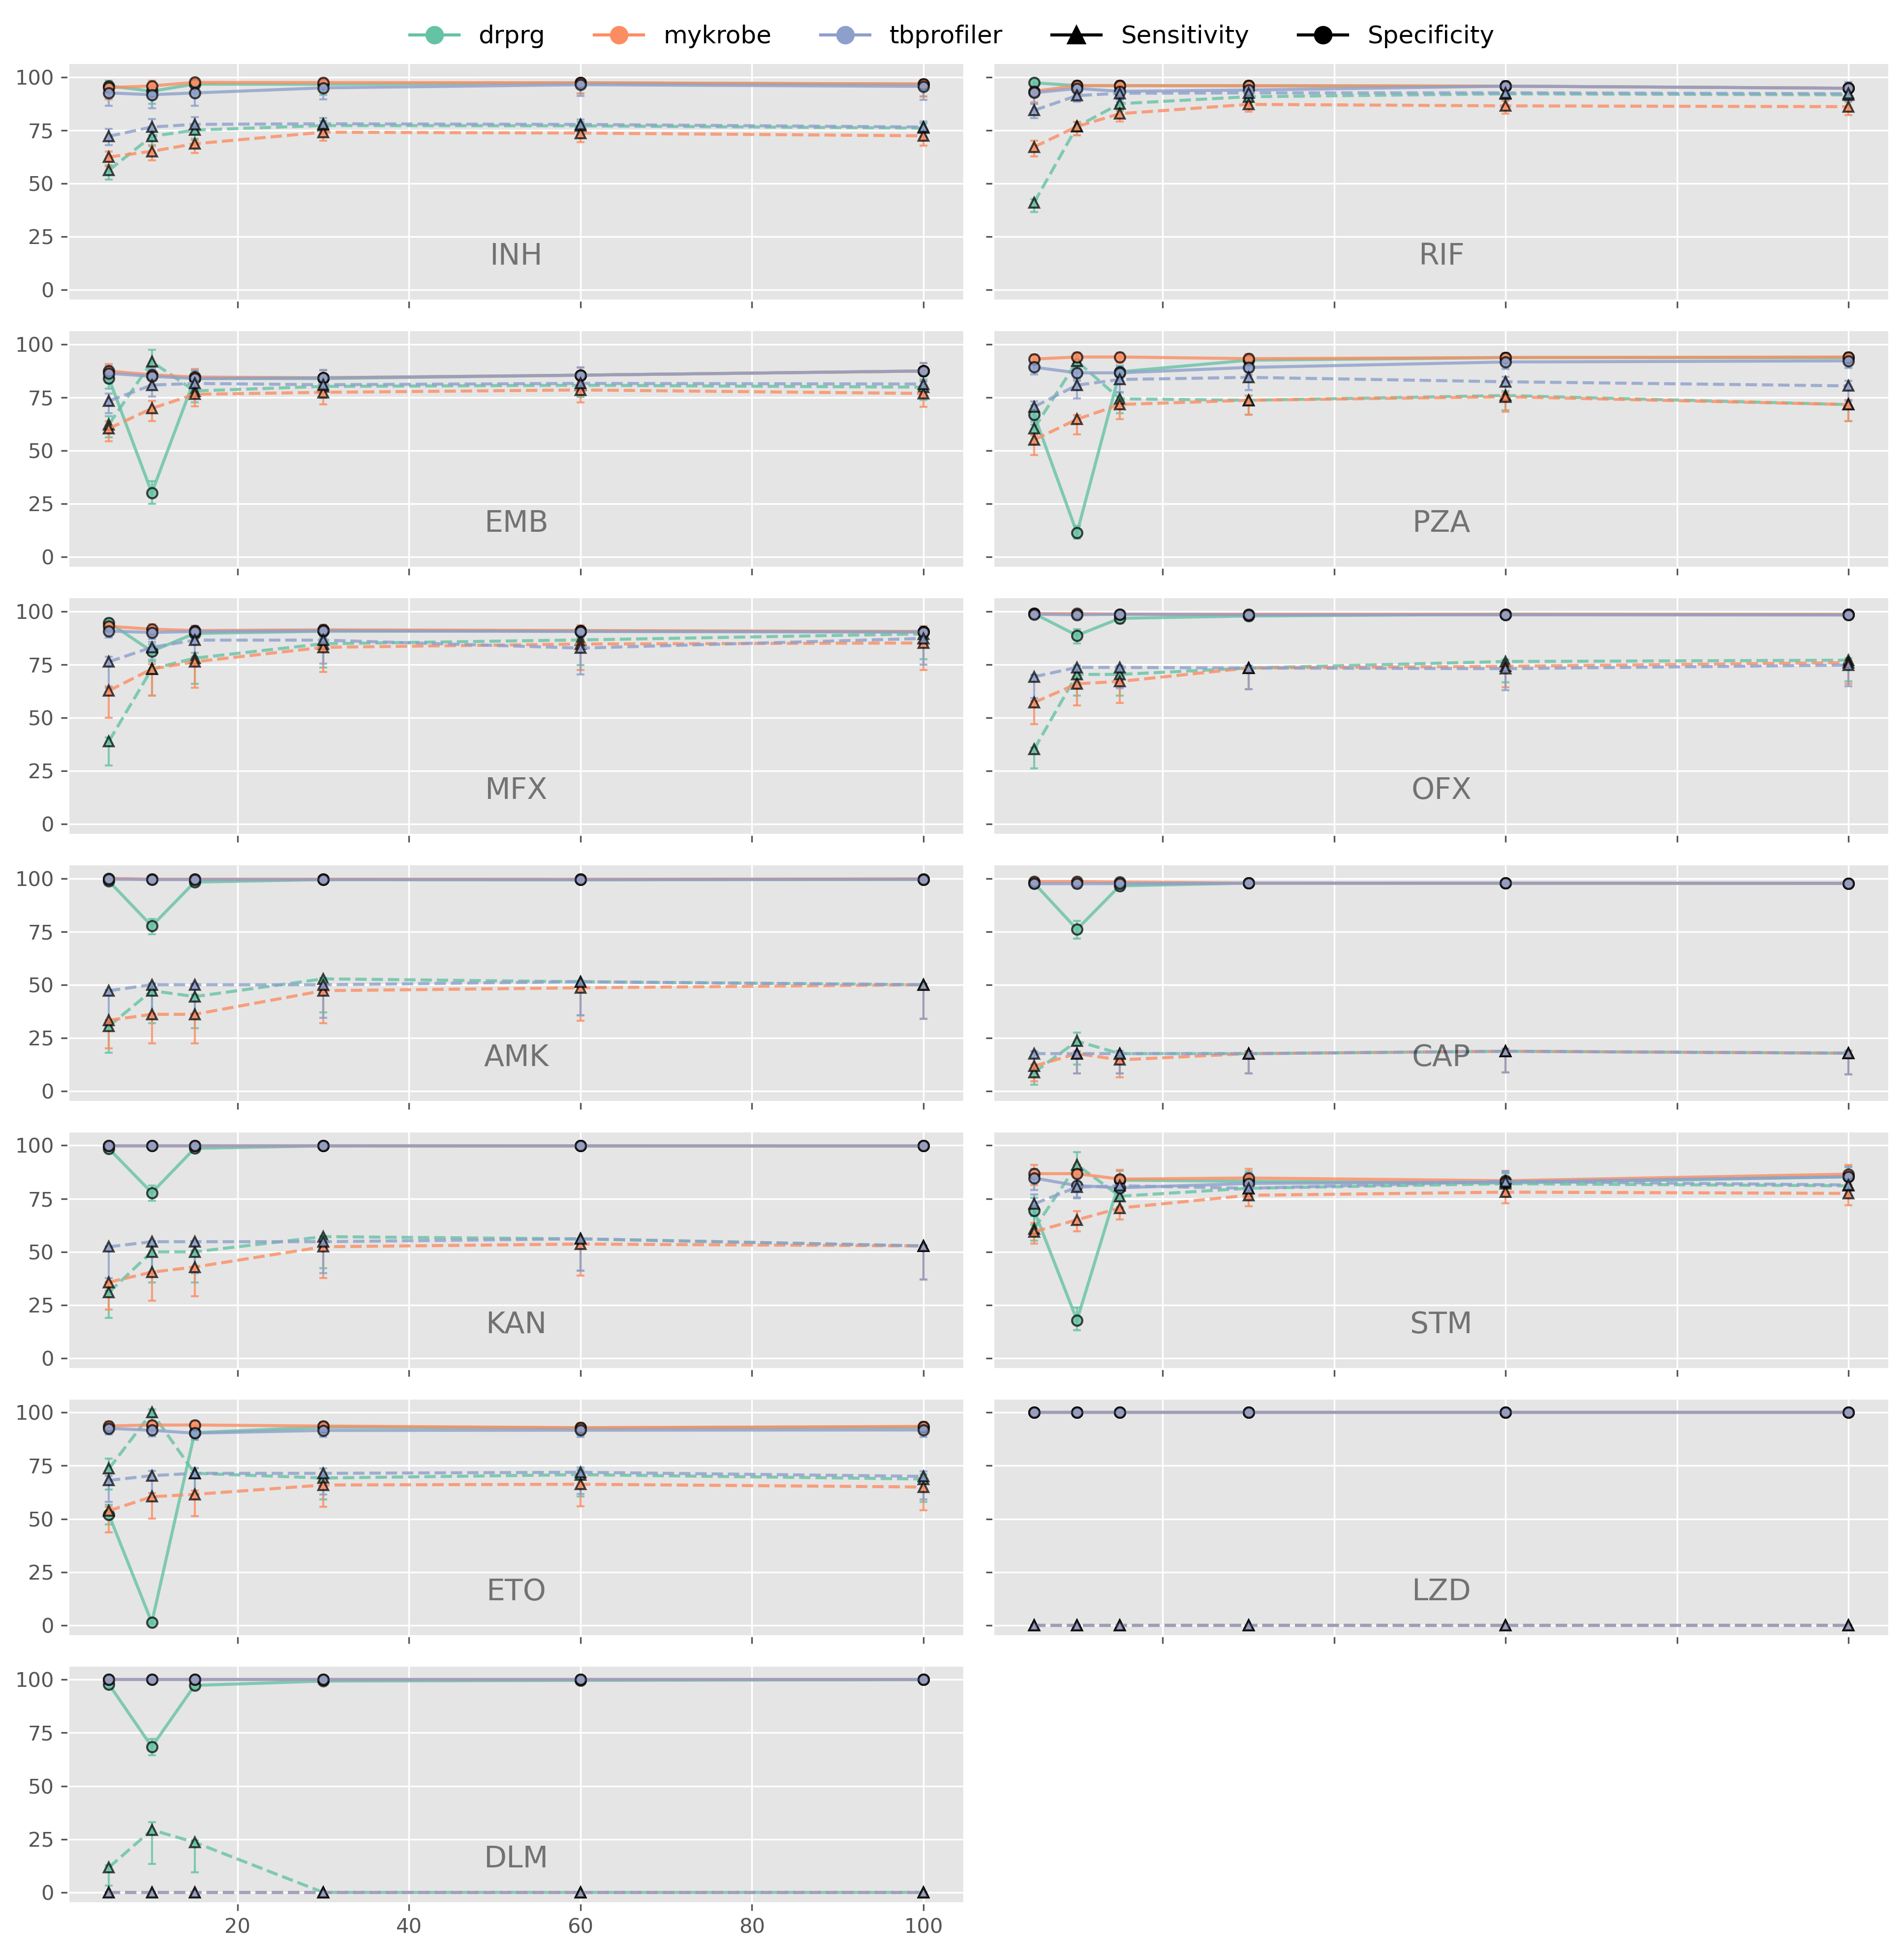

In [77]:
drugs = sorted(drugs, key=lambda d: drug_order.index(d))
min_cols = 2
ncols = min(min_cols, len(drugs))
nrows = math.ceil(len(drugs) / min_cols)

fig, axes = plt.subplots(
    figsize=(13, 13), 
    dpi=300, 
    ncols=ncols, 
    nrows=nrows, 
    tight_layout=True,
    sharex=True,
    sharey=True,
)

x = "depth"
y = "value"
elw = 1
marker_size = 5
capsize = 2
cmap = plt.get_cmap("Set2").colors
edge_alpha = 0.7
fs = 12
edgecol = mpl.colors.to_rgba("black", alpha=edge_alpha)
leg_marker_size = 8

sn_marker = "^"
sn_line = "--"
sp_marker = "o"
sp_line = "-"


for i, drug in enumerate(drugs):
    leghandles = []
    j = -1
    ax = axes.flatten()[i]
    for tool in tools:
        j += 1
        tool_sn_df = sn_df.query("tool==@tool and drug==@drug")
        tool_sp_df = sp_df.query("tool==@tool and drug==@drug")

        colour = mpl.colors.to_rgba(cmap[j], alpha=0.8)
        label = tool

        ax.set_title(long2short[drug], x=0.5, y=0.1, alpha=0.5)

        sp_ys = tool_sp_df["value"] * 100
        sp_lb = sp_ys - tool_sp_df["lower"] * 100
        sp_ub = tool_sp_df["upper"] * 100 - sp_ys
        sp_ub = [min(100, x) for x in sp_ub]


        plotprops = dict(
            label=label, 
            color=colour, 
            capsize=capsize, 
            elinewidth=elw,
            mec=edgecol,
            markersize=marker_size,
        )

        sp_bar = ax.errorbar(
            x=tool_sp_df[x], 
            y=sp_ys,
            yerr=[sp_lb, sp_ub],
            fmt=f"{sp_marker}{sp_line}",
            **plotprops
        )

        sn_ys = tool_sn_df["value"] * 100
        sn_lb = sn_ys - tool_sn_df["lower"] * 100
        sn_ub = tool_sn_df["upper"] * 100 - sn_ys
        sn_ub = [min(100, x) for x in sp_ub]



        sn_bar = ax.errorbar(
            x=tool_sn_df[x], 
            y=sn_ys,
            yerr=[sn_lb, sn_ub],
            fmt=f"{sn_marker}{sn_line}",
            **plotprops
        )

        h = mlines.Line2D([], [], color=cmap[j], marker=sp_marker,
                          markersize=leg_marker_size, label=label)
        leghandles.append(h)

        
leghandles.append(mlines.Line2D([], [], color="black", marker=sn_marker,
                          markersize=leg_marker_size, label="Sensitivity"))
leghandles.append(mlines.Line2D([], [], color="black", marker=sp_marker,
                          markersize=leg_marker_size, label="Specificity"))

legend_props = dict(
    loc="upper center", 
    prop=dict(size=fs), 
    frameon=False, 
    ncol=len(leghandles),
)
fig.legend(handles=leghandles, bbox_to_anchor=(0.5, 1.02), **legend_props)

empty_axes = range(len(drugs), nrows*ncols)
for i in empty_axes:
    ax = axes.flatten()[i]
    fig.delaxes(ax)

In [78]:
drugs

['isoniazid',
 'rifampicin',
 'ethambutol',
 'pyrazinamide',
 'moxifloxacin',
 'ofloxacin',
 'amikacin',
 'capreomycin',
 'kanamycin',
 'streptomycin',
 'ethionamide',
 'linezolid',
 'delamanid']